In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm  

df = pd.read_csv("QSurvey_Synthetic.csv", encoding='ISO-8859-1')
df['Treatment'] = df['FL_22_DO'].apply(lambda x: 1 if x == 'FL_24' else 0)



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x703387407470>>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


                            OLS Regression Results                            
Dep. Variable:                    DV1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.002676
Date:                Tue, 15 Jul 2025   Prob (F-statistic):              0.959
Time:                        18:19:25   Log-Likelihood:                -554.70
No. Observations:                 402   AIC:                             1113.
Df Residuals:                     400   BIC:                             1121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7015      0.068     54.434      0.0

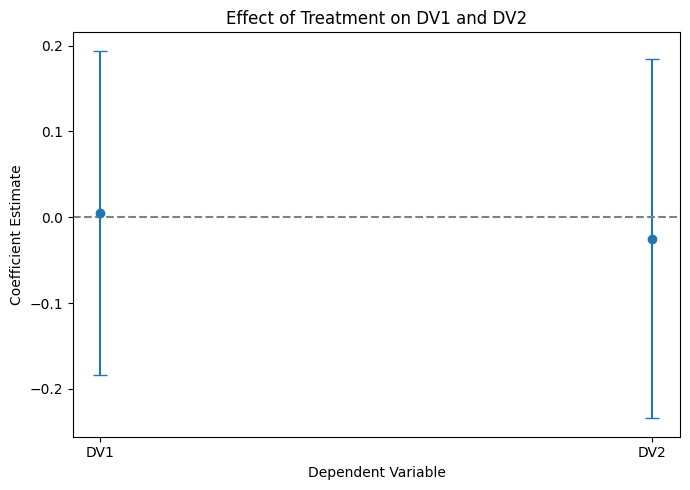

In [ ]:
df_clean = df[['DV1', 'DV2', 'Treatment']].dropna()

# regressions
X = sm.add_constant(df_clean['Treatment'])

model_dv1 = sm.OLS(df_clean['DV1'], X).fit()
model_dv2 = sm.OLS(df_clean['DV2'], X).fit()

# Print summaries
print(model_dv1.summary())
print(model_dv2.summary())

# Prepare data for plotting
coef_data = pd.DataFrame({
    'DV': ['DV1', 'DV2'],
    'coef': [model_dv1.params['Treatment'], model_dv2.params['Treatment']],
    'ci_low': [model_dv1.conf_int().loc['Treatment'][0], model_dv2.conf_int().loc['Treatment'][0]],
    'ci_high': [model_dv1.conf_int().loc['Treatment'][1], model_dv2.conf_int().loc['Treatment'][1]]
})

# Plot
plt.figure(figsize=(7, 5))
plt.errorbar(coef_data['DV'], coef_data['coef'], 
             yerr=[coef_data['coef'] - coef_data['ci_low'], coef_data['ci_high'] - coef_data['coef']], 
             fmt='o', capsize=5)
plt.axhline(0, color='grey', linestyle='--')
plt.title('Effect of Treatment on DV1 and DV2')
plt.ylabel('Coefficient Estimate')
plt.xlabel('Dependent Variable')
plt.tight_layout()
plt.show()

In [ ]:
# Moderator: Ideology - does being more or less variable have any impact with or without rhetorical bypassing?
df_subset = df[['DV2', 'FL_22_DO', 'Q4']].dropna()
df_subset = df_subset[df_subset['Q4'].isin(['Very liberal', 'Liberal', 'Moderate', 'Conservative', 'Very conservative'])]
df_subset['treatment'] = (df_subset['FL_22_DO'] == 'FL_24').astype(int)
df_subset['ideology'] = df_subset['Q4'].map({
    'Very liberal': 1,
    'Liberal': 2,
    'Moderate': 3,
    'Conservative': 4,
    'Very conservative': 5
})

# Filter to liberals and moderates only (ideology ≤ 3)
df_liberal = df_subset[df_subset['ideology'] <= 3]

# Add interaction term
df_liberal['interaction'] = df_liberal['treatment'] * df_liberal['ideology']

# Regression with interaction term
X_liberal = df_liberal[['treatment', 'ideology', 'interaction']]
X_liberal = sm.add_constant(X_liberal)
y_liberal = df_liberal['DV2']

model_liberal = sm.OLS(y_liberal, X_liberal).fit()
model_liberal.summary()


/tmp/ipykernel_1653/3831405517.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_liberal['interaction'] = df_liberal['treatment'] * df_liberal['ideology']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    DV2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.319
Date:                Tue, 15 Jul 2025   Prob (F-statistic):             0.0209
Time:                        18:19:46   Log-Likelihood:                -287.16
No. Observations:                 207   AIC:                             582.3
Df Residuals:                     203   BIC:                             595.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.2805      0.298      7.651      0.000       1.693       2.868
treatment      -0.8184      0.408     -2.005      0.046      -1.623      -0.014
ideology        0.0206      0.136      0.151      0.880      -0.248       0.289
interaction     0.3781      0.186      2.032      0.044       0.011       0.745
==============================================================================
Omnibus:                       12.175   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.044
Skew:                           0.400   Prob(JB):                       0.0109
Kurtosis:                       2.362   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/tmp/ipykernel_1653/3918291023.py:15: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=coef_df, y='term', x='coef', join=False)


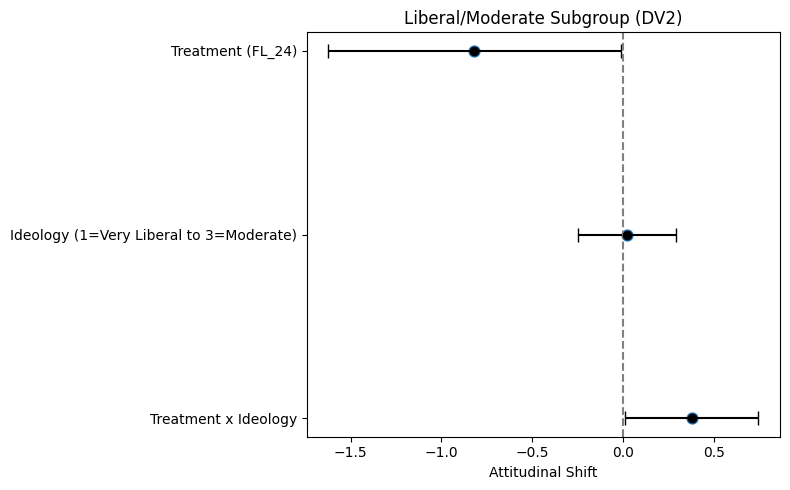

In [ ]:
coef_df = model_liberal.conf_int().reset_index()
coef_df.columns = ['term', 'ci_lower', 'ci_upper']
coef_df['coef'] = model_liberal.params.values
coef_df = coef_df[coef_df['term'] != 'const']

term_map = {
    'treatment': 'Treatment (FL_24)',
    'ideology': 'Ideology (1=Very Liberal to 3=Moderate)',
    'interaction': 'Treatment x Ideology'
}
coef_df['term'] = coef_df['term'].map(term_map)

# Plot the coefficients
plt.figure(figsize=(8, 5))
sns.pointplot(data=coef_df, y='term', x='coef', join=False)
plt.errorbar(
    x=coef_df['coef'], y=coef_df['term'],
    xerr=[coef_df['coef'] - coef_df['ci_lower'], coef_df['ci_upper'] - coef_df['coef']],
    fmt='o', color='black', capsize=5
)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Liberal/Moderate Subgroup (DV2)')
plt.xlabel('Attitudinal Shift')
plt.ylabel('')
plt.tight_layout()
plt.show()
